# Jerry's comments:

About the errors getting smaller when regularization is applied:
- nested CV
- rel error (so check what your output is, when it's very small, then errors are not that big, but if they are big, then the model is very good)


About PCA when relating them to the features
- take H: pxn (When decomposing X~WxH). X is MxN, W is MxP, and H is PxN

If you take the first two principles components from H, then you might get like:

          f1  f2 f3 f4
   
pc_1 [ 0.5, -0.3, 0.0, 0.1]

pc_2 [ 0.1,  0.8, 0.2, -0.2]

# Data Madness project - group 31

For this project we took crime data on a municipal level, with the goal to create an accurate predictor for the total crime in future years.
We predict the total crime number per capita based on a select amount of features we believed to potentially have impact on the value to be predicted. We preform checks to see if these features indeed show potential for a linear predictor. We use linear regression combined with k-fold cross validation to create and validate our results. Finally, we take into consideration several ethical viewpoints that come into view when dealing with crime statistics.

## Imports

Imports that we need to take care of.

In [1]:
import pandas as pd
import numpy as np
import re
from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from pandas import CategoricalDtype
from sklearn.model_selection import train_test_split

pd.set_option('mode.chained_assignment', None)

# Loading the data

Let's load the data into memory.
The data we use comes from the CBS, an independent goverment institute. The CBS's main task is to collect data about the dutch people and ask questions on all sorts of socio-economic topics.  Statline is the public database, where everyone can use data collected by the CBS.


In [2]:
dfs = {}
datasets = ["data/2018/84468NED_UntypedDataSet_17032023_184722.csv", "data/2017/83901NED_UntypedDataSet_17032023_184829.csv", "data/2016/83903NED_UntypedDataSet_17032023_184919.csv"]


for dataset in datasets:
    findings = re.findall(r"(201\d)", dataset)
    year = findings[0]
    df = pd.read_csv(filepath_or_buffer=dataset, delimiter=";")
    relative_columns = df.columns.to_list()[-5:] #there are five relative columns, skip these for now
    print(relative_columns)
    df = df.drop(columns=relative_columns)
    dfs[year] = df


# Reading in the features for each municipality possibly related to the total crime number.
features_crime = pd.read_csv("data/FeaturesMisdaad.csv", delimiter=";")

# Reading in the matching of municapility to province
df_municipality = pd.read_csv('data/Gemeenten alfabetisch 2018.csv', delimiter=";") #--> 380 rows, but 391 needed......

['TotaalVermogenVernielingEnGeweld_26', 'TotaalVermogensmisdrijven_27', 'TotaalDiefstalUitWoningSchuurED_28', 'VernielingMisdrijfTegenOpenbareOrde_29', 'GeweldsEnSeksueleMisdrijven_30']
['TotaalVermogenVernielingEnGeweld_26', 'TotaalVermogensmisdrijven_27', 'TotaalDiefstalUitWoningSchuurED_28', 'VernielingMisdrijfTegenOpenbareOrde_29', 'GeweldsEnSeksueleMisdrijven_30']
['TotaalVermogenVernielingEnGeweld_26', 'TotaalVermogensmisdrijven_27', 'TotaalDiefstalUitWoningSchuurED_28', 'VernielingMisdrijfTegenOpenbareOrde_29', 'GeweldsEnSeksueleMisdrijven_30']


# Data Cleaning and Transformation

Let's check if we could join them easily by comparing if they have the same headers.

In [3]:
for comb in combinations(dfs.keys(), r=2):
    year_0 = comb[0]
    year_1 = comb[1]
    if ((dfs[year_0].columns == dfs[year_1].columns).all() == False):
        print('Problem with combination', comb, ", not all columns match.")

Let's inspect if there is a data-related column. If there is, we can just join the table, else we need to make one to seperate the data of 2016, 2017, 2018 by.

In [4]:
dfs["2018"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16771 entries, 0 to 16770
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   ID                                      16771 non-null  int64 
 1   WijkenEnBuurten                         16771 non-null  object
 2   Gemeentenaam_1                          16771 non-null  object
 3   SoortRegio_2                            16771 non-null  object
 4   Codering_3                              16771 non-null  object
 5   Indelingswijziging_4                    16771 non-null  object
 6   AantalInwoners_5                        16771 non-null  int64 
 7   TotaalVermogenVernielingEnGeweld_6      16771 non-null  object
 8   TotaalVermogensmisdrijven_7             16771 non-null  object
 9   TotaalDiefstal_8                        16771 non-null  object
 10  Fietsendiefstal_9                       16771 non-null  object
 11  Di

--> There does not seem to be a year column, so let's make a year column.

In [5]:
#Create year column with the year of the data in it
for key in dfs.keys():
    df = dfs[key]
    df["year"] = [year for _ in range(len(df))]

In [6]:
dfs["2018"].columns

Index(['ID', 'WijkenEnBuurten', 'Gemeentenaam_1', 'SoortRegio_2', 'Codering_3',
       'Indelingswijziging_4', 'AantalInwoners_5',
       'TotaalVermogenVernielingEnGeweld_6', 'TotaalVermogensmisdrijven_7',
       'TotaalDiefstal_8', 'Fietsendiefstal_9',
       'DiefstalOverigeVervoermiddelen_10',
       'DiefstalUitVanafVervoermiddelen_11',
       'ZakkenrollerijStraatroofEnBeroving_12',
       'TotaalDiefstalUitWoningSchuurED_13',
       'DiefstalUitNietResidentieleGebouwen_14', 'OverigeDiefstalInbraak_15',
       'OverigeVermogensmisdrijven_16', 'TotaalVernielingTegenOpenbareOrde_17',
       'TotaalVernieling_18', 'VernielingAanAuto_19', 'OverigeVernieling_20',
       'OverigeVernielingTegenOpenbareOrde_21',
       'TotaalGeweldsEnSeksueleMisdrijven_22', 'Mishandeling_23',
       'BedreigingEnStalking_24', 'OverigeGeweldsEnSeksueleMisdrijven_25',
       'year'],
      dtype='object')

Let's remove the _NUMBER part of the column names.

In [7]:
columns = dfs["2018"].columns.to_list()
cleaned_columns = []
for col in columns:
    cleaned_col = re.sub(r"(_\d+)", repl="", string=col)
    #r"(_+\d)" --> regular expression that looks for an underscore with after that at least one digit.
    cleaned_columns.append(cleaned_col)

#Go over every dataframe and change the column names
column_renamer = {columns[i]: cleaned_columns[i] for i in range(len(cleaned_columns))}
for key in dfs.keys():
    dfs[key] = dfs[key].rename(columns=column_renamer)

Let's create a big dataframe which holds all the data together

In [8]:
for key in dfs.keys():
    df = dfs[key]
    df = df.reset_index()
    df["ID"] = [str(id)+"_"+key for id in df["ID"].to_list()]
    dfs[key] = df

df_all = pd.DataFrame(columns=dfs["2018"].columns)

for key in dfs.keys():
    df_all = pd.concat([df_all, dfs[key]])
    dfs[key] = dfs[key].drop(columns="ID")

df_all = df_all.drop(columns="index")

In [9]:
df_all

,ID,WijkenEnBuurten,Gemeentenaam,SoortRegio,Codering,Indelingswijziging,AantalInwoners,TotaalVermogenVernielingEnGeweld,TotaalVermogensmisdrijven,TotaalDiefstal,...,TotaalVernielingTegenOpenbareOrde,TotaalVernieling,VernielingAanAuto,OverigeVernieling,OverigeVernielingTegenOpenbareOrde,TotaalGeweldsEnSeksueleMisdrijven,Mishandeling,BedreigingEnStalking,OverigeGeweldsEnSeksueleMisdrijven,year
0,0_2018,GM1680,Aa en Hunze,Gemeente,GM1680,.,25390,423,284,199,...,73,59,14,45,14,66,26,23,17,2016
1,1_2018,WK168000,Aa en Hunze,Wijk,WK168000,1,3560,38,22,16,...,9,8,1,7,1,7,3,3,1,2016
2,2_2018,BU16800000,Aa en Hunze,Buurt,BU16800000,1,3415,37,21,15,...,9,8,1,7,1,7,3,3,1,2016
3,3_2018,BU16800009,Aa en Hunze,Buurt,BU16800009,1,145,1,1,1,...,0,0,0,0,0,0,0,0,0,2016
4,4_2018,WK168001,Aa en Hunze,Wijk,WK168001,1,1430,19,16,12,...,1,1,0,1,0,2,1,0,1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16188,16188_2016,BU01935150,Zwolle,Buurt,BU01935150,1,3199,33,20,13,...,9,9,2,7,0,4,0,4,0,2016
16189,16189_2016,BU01935160,Zwolle,Buurt,BU01935160,1,72,3,3,2,...,0,0,0,0,0,0,0,0,0,2016
16190,16190_2016,WK019352,Zwolle,Wijk,WK019352,1,867,17,9,6,...,6,6,1,5,0,2,0,0,2,2016
16191,16191_2016,BU01935200,Zwolle,Buurt,BU01935200,1,386,8,2,2,...,6,6,1,5,0,0,0,0,0,2016


Now, let's save it and try to load it (checking if it works).

In [10]:
df_all.to_csv(path_or_buf="data/all_data.csv", sep=";", index=False) #saving

In [11]:
df_all = pd.read_csv(filepath_or_buffer="data/all_data.csv", delimiter=";") #loading

Next, we realized that some of the '0' values were instead written as a '.', thus we decided to fix these 0's. Furthermore, some of the numerical data was represented as a string containing one or multiple spaces, thus the below functions fix these.

In [12]:
def fix_zeros(dataframes: dict[str, pd.DataFrame], key: str) -> dict[str, pd.DataFrame]:
    """
    Method that fixes the strings or "." or "    [number]" issues from the CBS data

    Args:
        dataframes (dict[str, pd.DataFrame]): dictionary where the key represents the year and the value a dataframe
        key (str): column where to fix the issue

    Returns:
        dict[str, pd.DataFrame]: dictionary where the key represents the year and the value a dataframe (fixed)
    """
    for dataframe in dataframes.values():
        dataframe[key] = dataframe[key].replace(r'(\s+)', "", regex=True) #replace all spaces with nothing
        dataframe[key] = dataframe[key].replace(r'(\.)', "0", regex=True) #replace the dots with 0
        dataframe[key] = dataframe[key].astype(int)

    return dfs

In [13]:
# Identified the columns to fix and applying our new functions to them
to_fix = ["TotaalVermogenVernielingEnGeweld", "TotaalVermogensmisdrijven", "TotaalDiefstal", "TotaalDiefstalUitWoningSchuurED", "TotaalVernielingTegenOpenbareOrde", "TotaalVernieling", "TotaalGeweldsEnSeksueleMisdrijven"]
for fixable in to_fix:
    dfs = fix_zeros(dataframes = dfs, key = fixable)

Below, we create a new dataframe from the original to only include each municipality and not also all neighbourhoods within this municipality. Furthermore, we also clean up the names since these might contain multiple spaces. We noticed this by running the commented cell below.

In [14]:
#Counter(df_all["Gemeentenaam"])

In [15]:
dfs_Gemeente_All = df_all[df_all['SoortRegio'] == "Gemeente"]
df_all["Gemeentenaam"] = df_all["Gemeentenaam"].replace(r'(\s+\s)', "", regex=True) #find all spaces with another space behind it and replace them by nothing

We also noticed that there were issues regarding the municipality numbering (special codes), again with spacings, so we fixed that with this issue. Again, we noticed this by running the commented cell below.

In [16]:
#Counter(dfs_Gemeente_All['Codering'])

In [17]:
#pick the first 6 items in the numbering, the spaces were only attached after the code.
dfs_Gemeente_All["Codering"] = [code[:6] for code in dfs_Gemeente_All['Codering'].to_list()]

Next, we convert the period column to a year column for the features data. 
The feature_crime dataframe will act as our features for the regression model. These features are all on municipal level. These features were selected by us, based on the presumtion that they might impact crime numbers. Features include:

- The amount of men and woman.
- A precentage of persons with a migration background.
- A precentage of rental housing, owner-occupied housing and others that dont fall into previous categories.
- Total number of jobs. (x1000)
- Total number of families, exculding students. (x1000)
- Precentage of income of family type. With types: One-person, One-parent and couple with- and without child.
- Precentage of people who earn there income as employee.
- Precentage of people who earn there income as private contractor.
- Number of unemployed.
- We later also add a one hot encoded column telling us if it the entry is in a certain province or not.

In [18]:
periods = features_crime["Perioden"].to_list()
periods = [period[:4] for period in periods]
features_crime = features_crime.drop(columns="Perioden")
features_crime["Year"] = periods

# Not all municipalities have features for our data, so we remove these municipalitites.
# Later, we will also check this using sets and ensure a correct mapping

features_crime.replace('', np.nan, inplace=True)
features_crime.dropna(inplace=True)
features_crime


,ID,RegioS,Mannen_2,Vrouwen_3,TotaalMetMigratieachtergrond_35,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,ParticuliereHuishoudensExclStudenten_121,TypeEenpersoonshuishouden_133,TypeEenoudergezin_134,TypePaarZonderKind_135,TypePaarMetKindEren_136,BronInkomenAlsWerknemer_137,BronInkomenAlsZelfstandige_138,Werkloosheid_155,Year
0,1618,GM1680,12603.0,12683.0,1584.0,92.0,70.7,27.7,1.6,5.6,10.9,25.0,24.6,33.8,34.1,33.1,42.2,510.0,2017
1,1619,GM1680,12666.0,12724.0,1644.0,92.0,73.1,25.4,1.5,6.0,11.0,25.7,25.0,33.9,34.0,33.2,44.0,410.0,2018
2,1620,GM1680,12659.0,12727.0,1707.0,92.0,74.1,25.7,0.2,6.1,11.1,26.2,26.3,35.0,36.6,34.5,47.7,310.0,2019
3,1646,GM0738,6615.0,6452.0,759.0,259.0,71.6,28.3,0.2,3.4,4.9,24.2,26.0,32.9,33.7,31.2,41.9,160.0,2017
4,1647,GM0738,6684.0,6469.0,789.0,261.0,72.4,26.9,0.6,3.6,5.0,25.3,26.4,33.1,34.0,31.8,43.1,120.0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,21891,GM0642,21643.0,22943.0,9831.0,2196.0,55.4,44.0,0.6,19.2,19.9,24.7,22.8,33.3,33.2,31.5,47.3,620.0,2018
2174,21892,GM0642,21656.0,22983.0,10111.0,2199.0,56.4,43.4,0.1,19.6,19.9,26.3,24.4,35.3,37.2,32.9,51.5,480.0,2019
2175,21918,GM0193,61727.0,63821.0,20559.0,1128.0,52.5,47.0,0.5,101.9,55.0,23.7,22.4,34.0,32.4,30.6,42.3,2400.0,2017
2176,21919,GM0193,62030.0,64086.0,21093.0,1135.0,52.3,47.2,0.5,103.0,55.8,24.1,23.2,33.5,33.2,30.9,43.8,2090.0,2018


In [19]:
features_crime

,ID,RegioS,Mannen_2,Vrouwen_3,TotaalMetMigratieachtergrond_35,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,ParticuliereHuishoudensExclStudenten_121,TypeEenpersoonshuishouden_133,TypeEenoudergezin_134,TypePaarZonderKind_135,TypePaarMetKindEren_136,BronInkomenAlsWerknemer_137,BronInkomenAlsZelfstandige_138,Werkloosheid_155,Year
0,1618,GM1680,12603.0,12683.0,1584.0,92.0,70.7,27.7,1.6,5.6,10.9,25.0,24.6,33.8,34.1,33.1,42.2,510.0,2017
1,1619,GM1680,12666.0,12724.0,1644.0,92.0,73.1,25.4,1.5,6.0,11.0,25.7,25.0,33.9,34.0,33.2,44.0,410.0,2018
2,1620,GM1680,12659.0,12727.0,1707.0,92.0,74.1,25.7,0.2,6.1,11.1,26.2,26.3,35.0,36.6,34.5,47.7,310.0,2019
3,1646,GM0738,6615.0,6452.0,759.0,259.0,71.6,28.3,0.2,3.4,4.9,24.2,26.0,32.9,33.7,31.2,41.9,160.0,2017
4,1647,GM0738,6684.0,6469.0,789.0,261.0,72.4,26.9,0.6,3.6,5.0,25.3,26.4,33.1,34.0,31.8,43.1,120.0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,21891,GM0642,21643.0,22943.0,9831.0,2196.0,55.4,44.0,0.6,19.2,19.9,24.7,22.8,33.3,33.2,31.5,47.3,620.0,2018
2174,21892,GM0642,21656.0,22983.0,10111.0,2199.0,56.4,43.4,0.1,19.6,19.9,26.3,24.4,35.3,37.2,32.9,51.5,480.0,2019
2175,21918,GM0193,61727.0,63821.0,20559.0,1128.0,52.5,47.0,0.5,101.9,55.0,23.7,22.4,34.0,32.4,30.6,42.3,2400.0,2017
2176,21919,GM0193,62030.0,64086.0,21093.0,1135.0,52.3,47.2,0.5,103.0,55.8,24.1,23.2,33.5,33.2,30.9,43.8,2090.0,2018


There was a slight difference between the municipalities for which we had the crime data and for which the features data was available. These needed to be aligned and the difference was asserted to be 0 after alignment.

In [20]:
A = set(dfs_Gemeente_All['Codering'])
B = set(features_crime['RegioS'])

s = A.intersection(B)

print('Shape of dataframe before removal', dfs_Gemeente_All.shape)
print('Shape of dataframe before removal', features_crime.shape)

dfs_Gemeente_All = dfs_Gemeente_All[dfs_Gemeente_All['Codering'].isin(list(s))] #keeping those where we have features for
features_crime = features_crime[features_crime['RegioS'].isin(list(s))] #keeping those where we have data for

print('Shape of dataframe after removal', dfs_Gemeente_All.shape)
print('Shape of dataframe after removal', features_crime.shape)

#Just to check that removal went okay
A = set(dfs_Gemeente_All['Codering'])
B = set(features_crime['RegioS'])

assert len(A.difference(B)) == 0
assert len(B.difference(A)) == 0

Shape of dataframe before removal (1158, 28)
Shape of dataframe before removal (1123, 19)
Shape of dataframe after removal (1155, 28)
Shape of dataframe after removal (1114, 19)


Next, we averaged the features over the three years for which the data was collected.

In [21]:
features_crime_average = features_crime.groupby('RegioS').mean()
features_crime_average

C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_12140\2181078583.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  features_crime_average = features_crime.groupby('RegioS').mean()


,ID,Mannen_2,Vrouwen_3,TotaalMetMigratieachtergrond_35,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,ParticuliereHuishoudensExclStudenten_121,TypePaarZonderKind_135,BronInkomenAlsWerknemer_137,Werkloosheid_155
RegioS,,,,,,,,,,,,,
GM0003,2515.0,5757.666667,6073.333333,1661.333333,497.333333,48.733333,51.133333,0.166667,3.766667,5.533333,28.900000,29.033333,196.666667
GM0005,2906.5,5238.000000,5239.000000,790.000000,235.000000,68.450000,31.200000,0.400000,3.200000,4.350000,31.150000,30.150000,175.000000
GM0007,3130.0,4534.000000,4385.000000,973.000000,82.000000,70.600000,28.400000,1.000000,1.700000,4.000000,29.000000,29.600000,150.000000
GM0009,4054.5,3611.500000,3678.500000,515.500000,161.000000,76.600000,23.300000,0.100000,1.150000,2.950000,32.300000,30.900000,105.000000
GM0010,5203.0,12481.000000,12367.000000,4439.333333,187.000000,61.600000,37.933333,0.466667,10.566667,11.466667,29.500000,30.066667,413.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1949,19679.5,23404.500000,22665.500000,3980.500000,161.500000,67.450000,32.100000,0.400000,13.450000,20.000000,30.000000,29.800000,665.000000
GM1950,20407.5,12486.500000,12455.000000,2594.000000,90.500000,66.800000,29.700000,3.400000,7.500000,11.100000,29.200000,30.300000,340.000000
GM1952,12903.5,30561.500000,30364.500000,8712.500000,217.500000,61.900000,37.500000,0.600000,19.250000,27.300000,30.150000,30.000000,970.000000


For the `dfs_gemeente_All` dataframe, it was identified that some of the numerical values were read in as strings (yes, again...), thus not being able to perform any calculations on. These strings have to be converted to a format we can use to then group them by the mean of each municipality.

In [22]:
def fix_integers(dataframe: pd.DataFrame, low: int, high: int) -> pd.DataFrame:
    """
    Fixes integers by removing any spaces in the data columns between low and high and making "." to 0

    Args:
        dataframe (pd.DataFrame): dataframe to be fixed
        low (int): first number of the column that needs fixing
        high (int): last number of the column that needs fixing

    Returns:
        pd.DataFrame: fixed dataframe
    """
    for i in range(low, high):
        dataframe.iloc[:,i] =  dataframe.iloc[:,i].replace(r'(\s+)', "", regex=True)
        dataframe.iloc[:,i] =  dataframe.iloc[:,i].replace(r'(\.)', "0", regex=True)
        dataframe.iloc[:,i] = dataframe.iloc[:,i].astype(int)

    return dataframe

df_all = fix_integers(df_all, low=6, high=25)
dfs_Gemeente_All = fix_integers(dfs_Gemeente_All, low=5, high=24)
dfs_Gemeente_All_average = dfs_Gemeente_All.groupby('Codering').mean()

C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_12140\4016657341.py:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataframe.iloc[:,i] = dataframe.iloc[:,i].astype(int)
C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_12140\4016657341.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs_Gemeente_All_average = dfs_Gemeente_All.groupby('Codering').mean()


The following is the concatenation of the features data, the province information and the crime data.

In [23]:
features_crime_average = features_crime_average.rename(columns={'RegioS':'Codering'}) #first rename RegioS to Codering
dfs_gemeente_and_features = pd.concat([dfs_Gemeente_All_average, features_crime_average], axis=1) #concatenate the dataframes

The municipality data did not correctly match 11 of the 391 values. Since this is a reasonable number, these 11 were done manually.

This has been done through a manual mapper. One can use the webpage of the CBS with the municipality code to find in which province the municipality is. We used: https://vocabs.cbs.nl/cbs_ned/nl/page/?uri=https%3A%2F%2Fvocabs.cbs.nl%2Fgeo%2Fdef%2Fgemeenten%2FCodePlaceHolder where ```CodePlaceHolder``` was replace with the municipality code.

In [24]:
municipality_codes = df_municipality['GemeentecodeGM']
provinces = df_municipality['Provincienaam']

#Auto mapper
mapper = {municipality_codes[i]: provinces[i] for i in range(len(provinces))}

#Let's see the missing municipality codes
A = set(dfs_gemeente_and_features.reset_index()['index'])
B = set(list(mapper.keys()))
print('Missing municipalities:', A.difference(B))

Missing municipalities: {'GM0048', 'GM0196', 'GM0018', 'GM0063', 'GM1908', 'GM0040', 'GM0140', 'GM1987', 'GM0070', 'GM0081', 'GM0007'}


In [25]:
#Additional entries for the mapper
mapper['GM0070'] = 'Friesland'
mapper['GM1987'] = 'Groningen'
mapper['GM0081'] = 'Friesland'
mapper['GM0007'] = 'Groningen'
mapper['GM0063'] = 'Friesland'
mapper['GM0018'] = 'Groningen'
mapper['GM0040'] = 'Groningen'
mapper['GM0196'] = 'Gelderland'
mapper['GM0048'] = 'Groningen'
mapper['GM0140'] = 'Friesland'
mapper['GM1908'] = 'Friesland'

dfs_gemeente_and_features = dfs_gemeente_and_features.reset_index()
dfs_gemeente_and_features["Province"] = dfs_gemeente_and_features['index'].replace(mapper)

#To check the provinces manually
print('All provinces:', np.unique(list(mapper.values())))

All provinces: ['Drenthe' 'Flevoland' 'Friesland' 'Gelderland' 'Groningen' 'Limburg'
 'Noord-Brabant' 'Noord-Holland' 'Overijssel' 'Utrecht' 'Zeeland'
 'Zuid-Holland']


Check for any NaNs

In [26]:
assert dfs_gemeente_and_features.isna().sum().sum() == 0

Creating a total crime category (sum of all crimes). Then dividing each type of crime by the total crime per municipality to find the proportion of each crime contributing to the total. Also creating a crime per capita variable for each category. This was done for visualization purposes.

In [27]:
dfs_gemeente_and_features['total_crime'] = dfs_gemeente_and_features.iloc[:,2:19].sum(axis=1)
dfs_gemeente_and_features['crime_per_capita'] = dfs_gemeente_and_features['total_crime'].div(dfs_gemeente_and_features['AantalInwoners'])
relative_crimes = dfs_gemeente_and_features.iloc[:,2:19].div(dfs_gemeente_and_features.total_crime, axis=0)
relative_crimes

,AantalInwoners,TotaalVermogenVernielingEnGeweld,TotaalVermogensmisdrijven,TotaalDiefstal,Fietsendiefstal,DiefstalOverigeVervoermiddelen,DiefstalUitVanafVervoermiddelen,ZakkenrollerijStraatroofEnBeroving,TotaalDiefstalUitWoningSchuurED,DiefstalUitNietResidentieleGebouwen,OverigeDiefstalInbraak,OverigeVermogensmisdrijven,TotaalVernielingTegenOpenbareOrde,TotaalVernieling,VernielingAanAuto,OverigeVernieling,OverigeVernielingTegenOpenbareOrde
0,0.913695,0.027023,0.016704,0.013103,0.002554,0.000664,0.000843,0.000230,0.002171,0.004291,0.002350,0.003601,0.004572,0.003627,0.001609,0.002018,0.000945
1,0.954360,0.013652,0.008909,0.005656,0.000760,0.000243,0.000395,0.000061,0.001794,0.000639,0.001764,0.003253,0.003010,0.002493,0.000912,0.001581,0.000517
2,0.939403,0.018746,0.011342,0.007982,0.000473,0.000315,0.000525,0.000000,0.002205,0.001733,0.002731,0.003361,0.003938,0.003308,0.000840,0.002468,0.000630
3,0.953565,0.013870,0.008913,0.005565,0.001261,0.000130,0.000391,0.000043,0.001130,0.001826,0.000783,0.003348,0.003174,0.002826,0.000783,0.002043,0.000348
4,0.899437,0.030935,0.018950,0.015396,0.002270,0.000408,0.001561,0.000516,0.002738,0.004840,0.003062,0.003555,0.005836,0.004659,0.001753,0.002906,0.001177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,0.944163,0.016995,0.010217,0.007576,0.001310,0.000410,0.000983,0.000041,0.001822,0.001147,0.001863,0.002641,0.003829,0.003174,0.001556,0.001618,0.000655
387,0.889610,0.032977,0.022453,0.019534,0.001153,0.000216,0.001225,0.000324,0.002811,0.010271,0.003532,0.002919,0.004793,0.003388,0.001370,0.002018,0.001406
388,0.930180,0.021869,0.012758,0.008928,0.001663,0.000549,0.000488,0.000092,0.002014,0.002106,0.002014,0.003831,0.004838,0.003831,0.001267,0.002564,0.001007
389,0.921202,0.022606,0.015739,0.012171,0.001988,0.000694,0.002101,0.000278,0.003195,0.001493,0.002422,0.003568,0.004306,0.003933,0.001797,0.002136,0.000373


# Visualizations

## Let's do so EDA when considering all datasets.

Firstly we wanted to have a look at the spread of our the crimes over the three given years. There is a slight, but not extreme, decrease over the three relevant years.

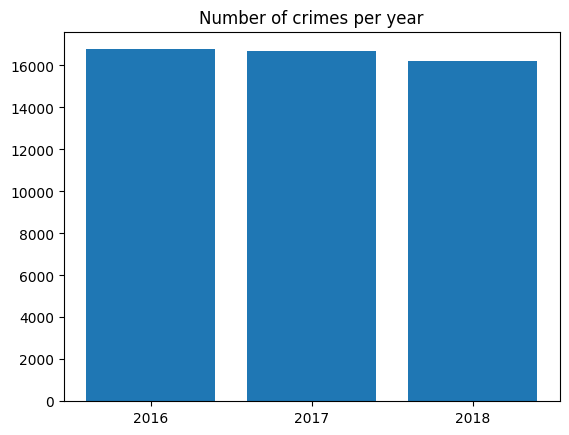

In [28]:
number_of_crimes = [len(dfs[x]) for x in dfs.keys()]
years = list(dfs.keys())

# Sort based on the year to give a good visualization about the time
number_of_crimes_sorted = [x for _, x in sorted(zip(years, number_of_crimes))]
years.sort()

plt.bar(x=years, height=number_of_crimes)
plt.title("Number of crimes per year")
plt.show()

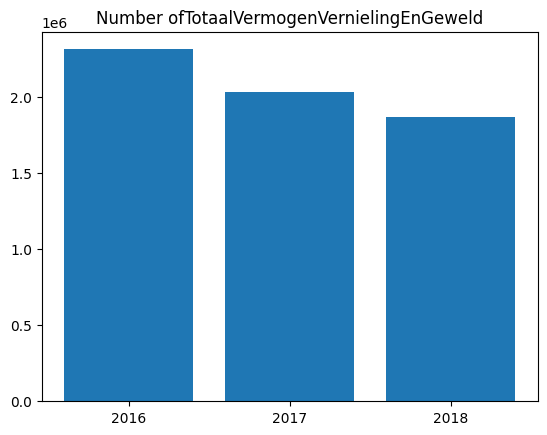

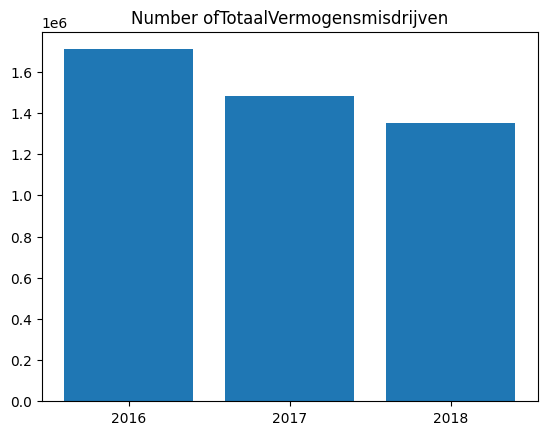

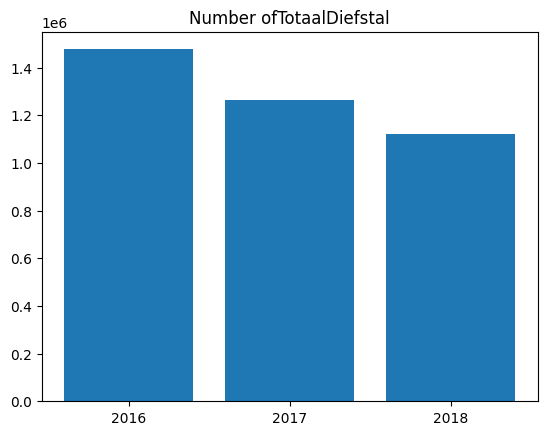

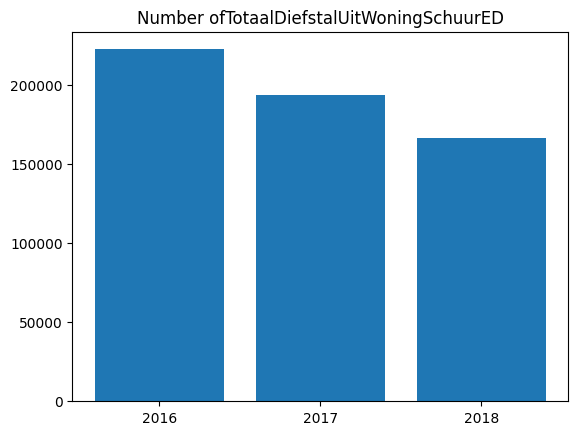

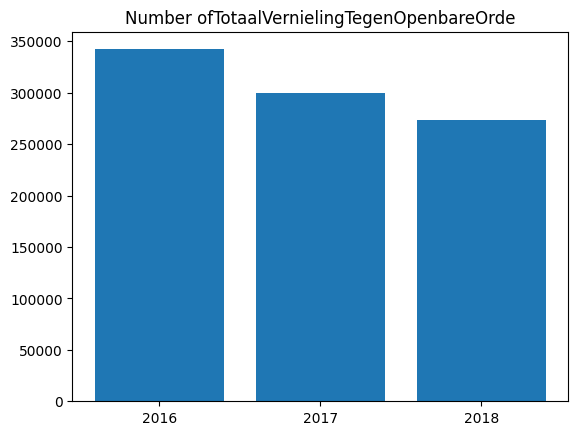

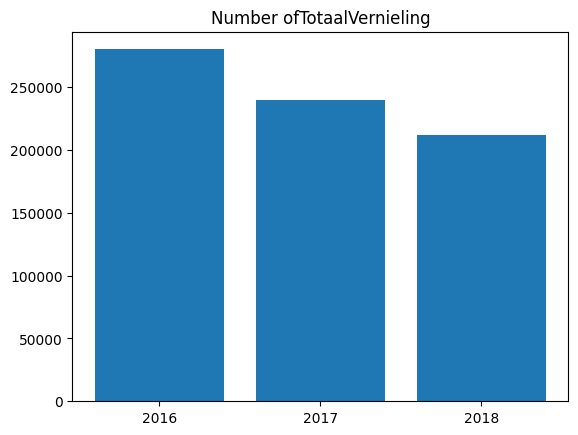

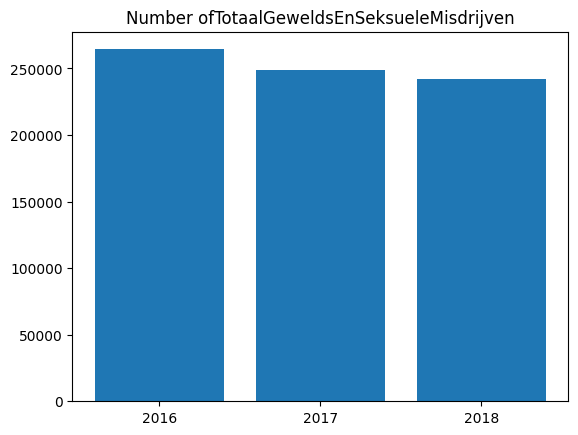

In [29]:
for fixed in to_fix:
    height = [sum(dfs[x][fixed]) for x in dfs.keys()]
    years = list(dfs.keys())

    # Sort based on the year to give a good visualization about the time
    height = [x for _, x in sorted(zip(years, height))]
    years.sort()

    plt.bar(x=years, height=height)
    plt.title(str("Number of" + fixed))
    plt.show()

## Let's do some EDA when considering each dataset separately.

We first needed to create a tuple of the name of the province and the actual number.

In [30]:
tuples_total_crime = []
tuples_crime_per_capita = []
dfs_province = dfs_gemeente_and_features.groupby('Province').sum()
dfs_province = dfs_province.reset_index()

for i in range(len(dfs_province)):
    tuples_total_crime.append((dfs_province['Province'][i], dfs_province['total_crime'][i]))
    tuples_crime_per_capita.append((dfs_province['Province'][i], dfs_province['crime_per_capita'][i]))

C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_12140\1208038413.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs_province = dfs_gemeente_and_features.groupby('Province').sum()


To reduce overplotting for the x-labels, we used the official abbreviations for the provinces.

In [31]:
short_province = {
    'Friesland': 'F',
    'Drenthe': 'D',
    'Overijssel': 'O',
    'Flevoland': 'Fle',
    'Gelderland': 'Gld',
    'Utrecht': 'U',
    'Noord-Holland': 'NH',
    'Zuid-Holland': 'ZH',
    'Zeeland': 'Z',
    'Noord-Brabant': 'NB',
    'Limburg': 'L',
    'Zeeland': 'Z',
    'Groningen': 'Gr'
}

Plot total crime per province

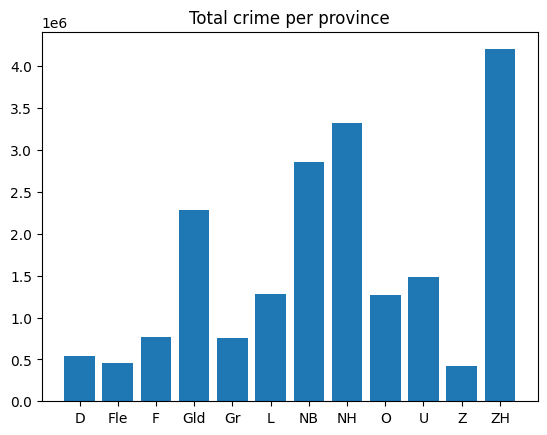

In [32]:
x = [short_province[tuples_total_crime[i][0]] for i in range(len(tuples_total_crime))]
height = [tuples_total_crime[i][1] for i in range(len(tuples_total_crime))]
plt.bar(x=x, height=height)
plt.title("Total crime per province")
plt.show()

Plot crime per capita per province

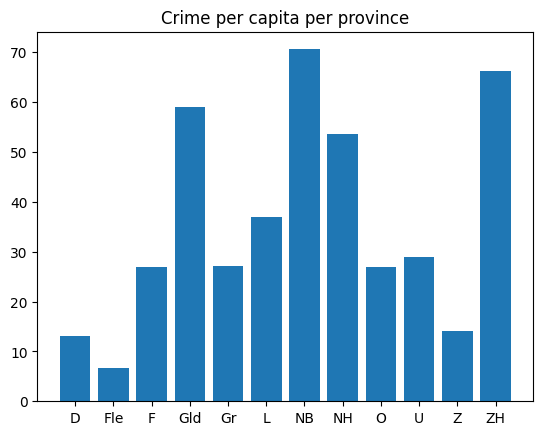

In [33]:
x = [short_province[tuples_crime_per_capita[i][0]] for i in range(len(tuples_crime_per_capita))]
height = [tuples_crime_per_capita[i][1] for i in range(len(tuples_crime_per_capita))]
plt.bar(x=x, height=height)
plt.title("Crime per capita per province")
plt.show()

Above we see the total crime per province and the crime per capita per province. This shows that using the crime per capita data may be more indicative for the provinces.

Let's have a look at the correlation for the entire dataframe.

                                     AantalInwoners  \
AantalInwoners                             1.000000   
TotaalVermogenVernielingEnGeweld          -0.996732   
TotaalVermogensmisdrijven                 -0.988437   
TotaalDiefstal                            -0.985249   
Fietsendiefstal                           -0.795305   
DiefstalOverigeVervoermiddelen            -0.730504   
DiefstalUitVanafVervoermiddelen           -0.717067   
ZakkenrollerijStraatroofEnBeroving        -0.745472   
TotaalDiefstalUitWoningSchuurED           -0.612326   
DiefstalUitNietResidentieleGebouwen       -0.782971   
OverigeDiefstalInbraak                    -0.781990   
OverigeVermogensmisdrijven                -0.701734   
TotaalVernielingTegenOpenbareOrde         -0.741464   
TotaalVernieling                          -0.682516   
VernielingAanAuto                         -0.690268   
OverigeVernieling                         -0.531982   
OverigeVernielingTegenOpenbareOrde        -0.762430   

         

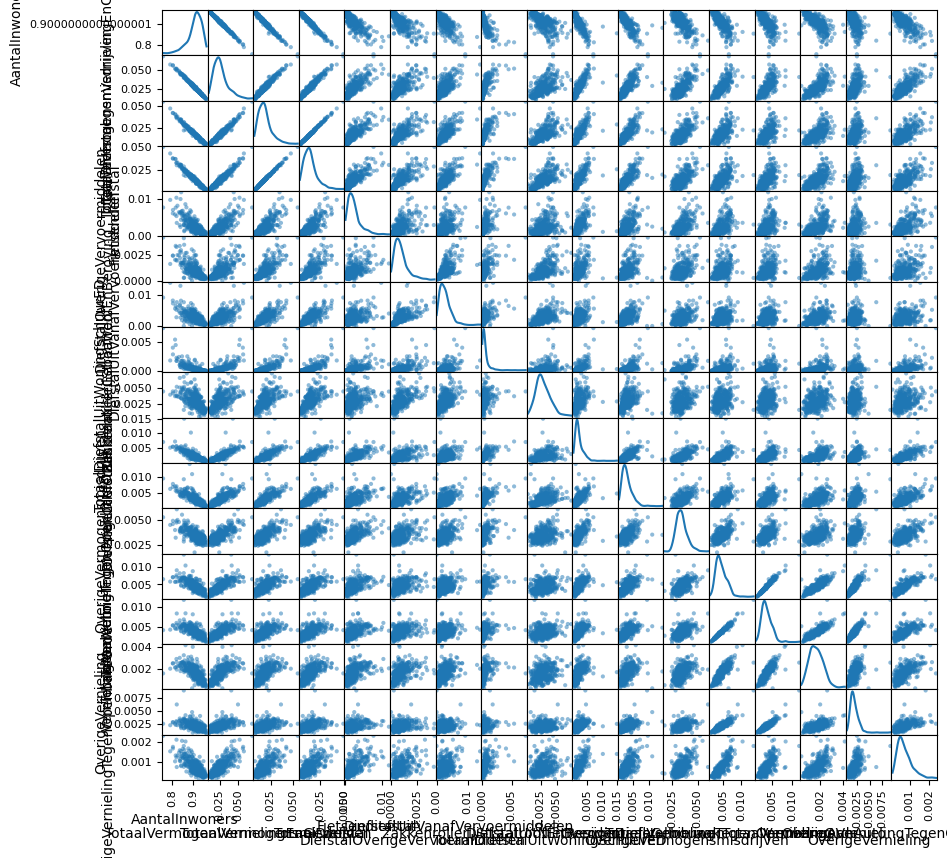

In [34]:
print(relative_crimes.corr())
pd.plotting.scatter_matrix(relative_crimes, figsize=(10, 10), diagonal='kde')
plt.show()

The plotting of this giant plot is not that sensible since some theft/crime numbers are made up of each other. Therefore, we will later investigate the main principle components (dimensionality reduction) and work with those.

The plot below shows the spread and distribution of the data.

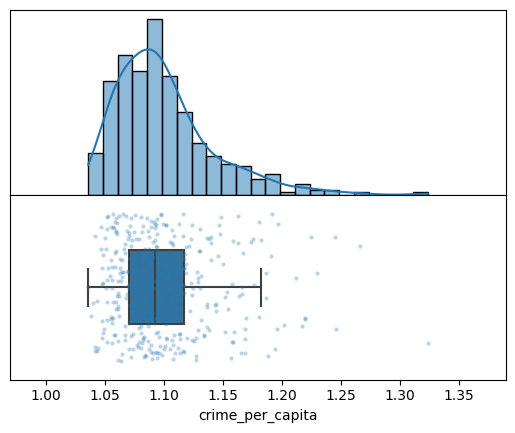

In [35]:
# Plot inspiration from Data Analysis course notebook.

fig, axs = plt.subplots(nrows=2)

sns.histplot(
    dfs_gemeente_and_features['crime_per_capita'],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    dfs_gemeente_and_features['crime_per_capita'], 
    orient='h',
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    dfs_gemeente_and_features['crime_per_capita'],
    orient='h',
    width=0.4, 
    ax=axs[1],
    showfliers=False,
)

spacer = np.max(dfs_gemeente_and_features['crime_per_capita']) * 0.05
xmin = np.min(dfs_gemeente_and_features['crime_per_capita']) - spacer
xmax = np.max(dfs_gemeente_and_features['crime_per_capita']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

plt.subplots_adjust(hspace=0)
axs[1].set_facecolor('white')

The following plots below were created to get a feeling for which features had a strong correlation (positive or negative) with the crime_per_capita value.

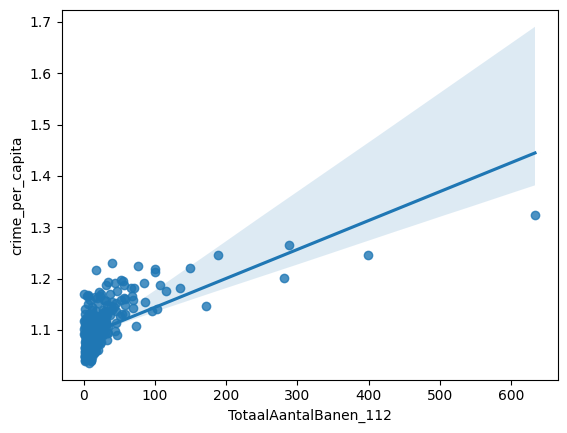

In [36]:
sns.regplot(x=dfs_gemeente_and_features['TotaalAantalBanen_112'], y=dfs_gemeente_and_features['crime_per_capita'])
plt.show()

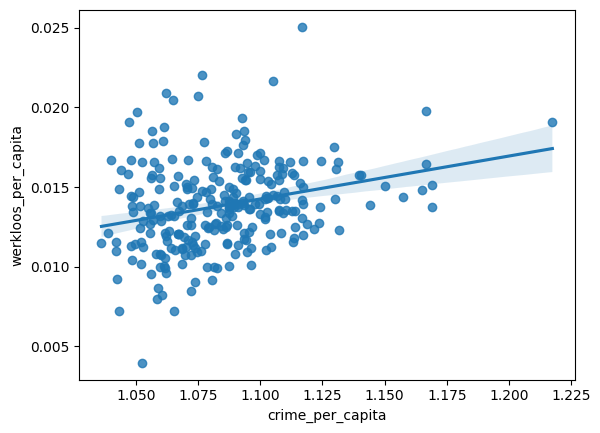

In [37]:
noCity = dfs_gemeente_and_features.loc[dfs_gemeente_and_features['AantalInwoners']<40000] 
noCity['werkloos_per_capita'] = noCity['Werkloosheid_155'].div(noCity['AantalInwoners'])
sns.regplot(x=noCity['crime_per_capita'], y=noCity['werkloos_per_capita'])

plt.show()

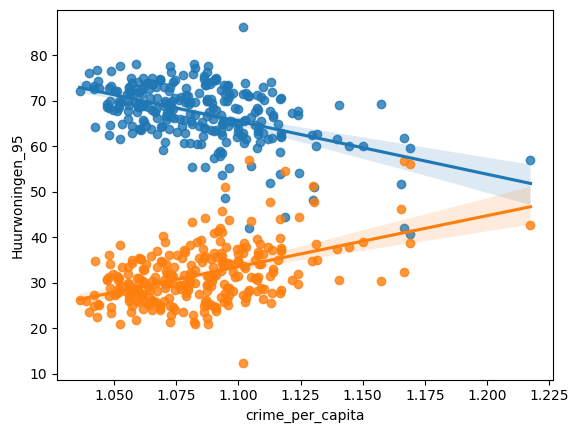

In [38]:
sns.regplot(x=noCity['crime_per_capita'], y=noCity['Koopwoningen_94'])
sns.regplot(x=noCity['crime_per_capita'], y=noCity['Huurwoningen_95'])

plt.show()

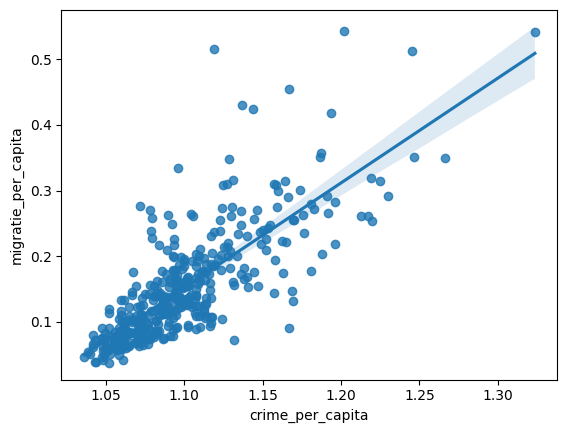

In [39]:
dfs_gemeente_and_features['migratie_per_capita'] = dfs_gemeente_and_features['TotaalMetMigratieachtergrond_35'].div(dfs_gemeente_and_features['AantalInwoners'])
sns.regplot(x=dfs_gemeente_and_features['crime_per_capita'], y=dfs_gemeente_and_features['migratie_per_capita'])

plt.show()

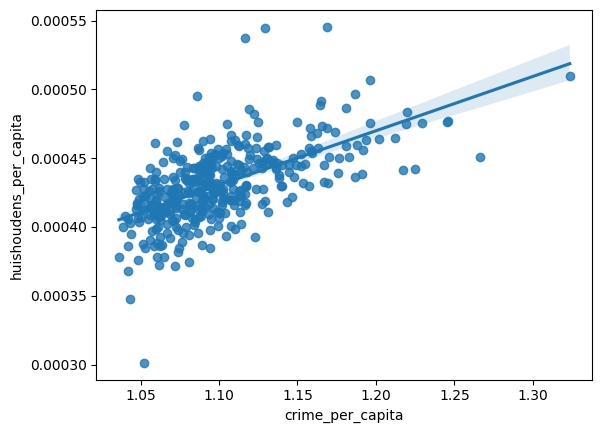

In [40]:
dfs_gemeente_and_features['huishoudens_per_capita'] = dfs_gemeente_and_features['ParticuliereHuishoudensExclStudenten_121'].div(dfs_gemeente_and_features['AantalInwoners'])

sns.regplot(x=dfs_gemeente_and_features['crime_per_capita'], y=dfs_gemeente_and_features['huishoudens_per_capita'])

plt.show()

Given that we identified the per capita information to be more useful than the total values, the features that were based on totals were divided by the total number of residents in the respective municipality to also make these per capita values.

In [41]:
relative_gemeente_features = dfs_gemeente_and_features.iloc[:,21:]
relative_gemeente_features['Bevolkingsdichtheid_57'] = relative_gemeente_features['Bevolkingsdichtheid_57'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)
relative_gemeente_features['TotaalAantalBanen_112'] = relative_gemeente_features['TotaalAantalBanen_112'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)
relative_gemeente_features['Werkloosheid_155'] = relative_gemeente_features['Werkloosheid_155'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)
relative_gemeente_features['Mannen_2'] = relative_gemeente_features['Mannen_2'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)
relative_gemeente_features['Vrouwen_3'] = relative_gemeente_features['Vrouwen_3'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)

relative_gemeente_features.drop(columns=['TotaalMetMigratieachtergrond_35','ParticuliereHuishoudensExclStudenten_121'], inplace=True)

relative_gemeente_features

,ID,Mannen_2,Vrouwen_3,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,TypePaarZonderKind_135,BronInkomenAlsWerknemer_137,Werkloosheid_155,Province,total_crime,crime_per_capita,migratie_per_capita,huishoudens_per_capita
0,2515.0,0.482850,0.509323,0.041707,48.733333,51.133333,0.166667,0.000316,28.900000,29.033333,0.016493,Groningen,13050.666667,1.094457,0.139323,0.000464
1,2906.5,0.500653,0.500749,0.022462,68.450000,31.200000,0.400000,0.000306,31.150000,30.150000,0.016727,Groningen,10962.666667,1.047822,0.075509,0.000416
2,3130.0,0.506875,0.490218,0.009167,70.600000,28.400000,1.000000,0.000190,29.000000,29.600000,0.016769,Groningen,9522.000000,1.064505,0.108776,0.000447
3,4054.5,0.494004,0.503169,0.022023,76.600000,23.300000,0.100000,0.000157,32.300000,30.900000,0.014363,Groningen,7666.666667,1.048696,0.070513,0.000404
4,5203.0,0.499927,0.495360,0.007490,61.600000,37.933333,0.466667,0.000423,29.500000,30.066667,0.016556,Groningen,27757.000000,1.111807,0.177818,0.000459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,19679.5,0.507558,0.491531,0.003502,67.450000,32.100000,0.400000,0.000292,30.000000,29.800000,0.014421,Friesland,48839.000000,1.059139,0.086322,0.000434
387,20407.5,0.505854,0.504578,0.003666,66.800000,29.700000,3.400000,0.000304,29.200000,30.300000,0.013774,Groningen,27747.000000,1.124088,0.105088,0.000450
388,12903.5,0.501411,0.498179,0.003568,61.900000,37.500000,0.600000,0.000316,30.150000,30.000000,0.015914,Groningen,65526.000000,1.075060,0.142943,0.000448
389,13211.0,0.504448,0.503590,0.009537,65.366667,34.500000,0.133333,0.000460,31.166667,31.266667,0.014512,Gelderland,38397.666667,1.085538,0.122253,0.000433


## One Hot Encoding

The province that the municipality is located in was one-hot encoded to be a feature in the model

In [42]:
cats = list(short_province.keys()) #we can use the mapper we used earlier

cat_type = CategoricalDtype(categories=cats)
relative_gemeente_features['Province'] = relative_gemeente_features['Province'].astype(cat_type)
relative_gemeente_features = pd.get_dummies(relative_gemeente_features,
                          prefix='pro',
                          columns=['Province'], 
                          drop_first=True)

relative_gemeente_features

,ID,Mannen_2,Vrouwen_3,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,TypePaarZonderKind_135,BronInkomenAlsWerknemer_137,...,pro_Overijssel,pro_Flevoland,pro_Gelderland,pro_Utrecht,pro_Noord-Holland,pro_Zuid-Holland,pro_Zeeland,pro_Noord-Brabant,pro_Limburg,pro_Groningen
0,2515.0,0.482850,0.509323,0.041707,48.733333,51.133333,0.166667,0.000316,28.900000,29.033333,...,0,0,0,0,0,0,0,0,0,1
1,2906.5,0.500653,0.500749,0.022462,68.450000,31.200000,0.400000,0.000306,31.150000,30.150000,...,0,0,0,0,0,0,0,0,0,1
2,3130.0,0.506875,0.490218,0.009167,70.600000,28.400000,1.000000,0.000190,29.000000,29.600000,...,0,0,0,0,0,0,0,0,0,1
3,4054.5,0.494004,0.503169,0.022023,76.600000,23.300000,0.100000,0.000157,32.300000,30.900000,...,0,0,0,0,0,0,0,0,0,1
4,5203.0,0.499927,0.495360,0.007490,61.600000,37.933333,0.466667,0.000423,29.500000,30.066667,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,19679.5,0.507558,0.491531,0.003502,67.450000,32.100000,0.400000,0.000292,30.000000,29.800000,...,0,0,0,0,0,0,0,0,0,0
387,20407.5,0.505854,0.504578,0.003666,66.800000,29.700000,3.400000,0.000304,29.200000,30.300000,...,0,0,0,0,0,0,0,0,0,1
388,12903.5,0.501411,0.498179,0.003568,61.900000,37.500000,0.600000,0.000316,30.150000,30.000000,...,0,0,0,0,0,0,0,0,0,1
389,13211.0,0.504448,0.503590,0.009537,65.366667,34.500000,0.133333,0.000460,31.166667,31.266667,...,0,0,1,0,0,0,0,0,0,0


## Dimensionality Reduction using PCA/SVD

Since there are so many features, let's have a look if we can reduce the dimensionality by PCA and SVD.

In [43]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

def dataframe_PCA(data: pd.DataFrame, columns_to_drop: list, limit_components: int = -1) -> pd.DataFrame:
    """
    Generates PCA dataframe by the data. It also offers some cleaning and it has automatic scaling.

    Args:
        data (pd.DataFrame): data that needs to be cleaned (with column removal) and scaled
        columns_to_drop (list): columns to drop for cleaning
        limit_components (int, optional): limits the amount of components for PCA. Defaults to -1 which is no limit.

    Returns:
        pd.DataFrame: PCA dataframe
    """
    cleaned_data = data.drop(columns=columns_to_drop) # Some cleaning before PCA
    print(cleaned_data.columns)
    X = scale(cleaned_data.values) # Scale dataset

    # Create PCA and transform to new coordinate system
    if (limit_components == -1):
        PCA_model = PCA()
    else:
        PCA_model = PCA(limit_components)
    X_PCA = PCA_model.fit_transform(X)

    # Create new DataFrame
    columns = ["PC_" + str(i) for i in range(len(cleaned_data.columns))]
    df_PCA = pd.DataFrame(X_PCA, columns=columns)

    print(PCA_model.singular_values_)
    print(PCA_model.get_feature_names_out())

    return df_PCA

df_PCA = dataframe_PCA(data=relative_gemeente_features, columns_to_drop=['ID'])

Index(['Mannen_2', 'Vrouwen_3', 'Bevolkingsdichtheid_57', 'Koopwoningen_94',
       'Huurwoningen_95', 'EigendomOnbekend_96', 'TotaalAantalBanen_112',
       'TypePaarZonderKind_135', 'BronInkomenAlsWerknemer_137',
       'Werkloosheid_155', 'total_crime', 'crime_per_capita',
       'migratie_per_capita', 'huishoudens_per_capita', 'pro_Drenthe',
       'pro_Overijssel', 'pro_Flevoland', 'pro_Gelderland', 'pro_Utrecht',
       'pro_Noord-Holland', 'pro_Zuid-Holland', 'pro_Zeeland',
       'pro_Noord-Brabant', 'pro_Limburg', 'pro_Groningen'],
      dtype='object')
[44.50814837 34.99466951 25.11337434 23.76152606 23.05903702 21.65301825
 21.22489747 20.98029    20.86659109 20.39981524 20.2780504  19.55014106
 17.71790159 17.42301843 17.14543704 15.25646373 12.87460496 12.70497098
 11.09038517  9.21206332  8.636392    7.10538852  4.405695    3.76324628
  0.05198471]
['pca0' 'pca1' 'pca2' 'pca3' 'pca4' 'pca5' 'pca6' 'pca7' 'pca8' 'pca9'
 'pca10' 'pca11' 'pca12' 'pca13' 'pca14' 'pca15' 'pca1

In [44]:
df_PCA

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24
0,1.878612,-2.143139,-3.137724,0.719116,-0.638509,-2.272971,-0.036186,0.690425,0.038722,-2.181370,...,0.859304,0.983156,-1.157350,0.454764,0.256550,0.484034,0.267529,-0.219213,0.113967,-0.002811
1,-1.761272,-1.811055,-1.882019,0.034824,-0.676295,-1.978691,0.101919,0.904915,-0.044143,-1.823720,...,1.279644,0.628011,0.271702,-0.083292,-0.324587,0.347947,0.284360,0.066907,-0.101838,-0.004851
2,-1.851290,-2.727043,-2.133068,-0.653132,-0.415066,-1.310143,0.304986,1.109977,-0.092377,-1.828956,...,0.312765,0.396763,0.456423,0.344085,0.047194,-0.725080,0.295908,-0.021053,-0.006206,0.000163
3,-2.969215,-0.838225,-2.132126,0.020922,-0.838170,-1.978719,-0.272747,0.787385,-0.006353,-1.908255,...,1.058132,1.071245,0.113499,-0.550205,-0.213951,-0.276844,-0.160621,0.495270,-0.017912,-0.001226
4,0.527385,-2.668060,-1.551293,-0.360837,-0.450783,-1.583772,0.064394,0.906584,0.024207,-1.948897,...,1.317224,0.273380,-0.114410,0.744454,0.082956,-0.820503,0.224902,-0.034868,0.224544,0.000163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,-1.552960,-1.665773,-0.070851,0.181788,-0.400971,-0.021131,-0.100816,0.100367,-0.121955,-0.063134,...,-0.759064,-0.577700,-0.124078,0.083430,0.396966,0.253315,0.348641,0.322152,0.686560,0.003780
387,-0.694559,-2.253472,-1.813653,-0.978094,1.870476,-0.197799,0.980847,1.568410,0.127992,-1.646683,...,0.743536,1.037792,-0.309893,-0.431082,0.053983,-1.080742,-0.498124,-0.153539,0.207062,0.009528
388,-0.205770,-2.490920,-1.635933,-0.176886,-0.299459,-1.636911,0.147737,1.095129,-0.012591,-1.936065,...,0.739787,0.613220,-0.329909,0.399391,-0.059927,-0.157239,0.521799,-0.057718,0.067350,-0.000138
389,-0.484294,-0.960007,0.397189,1.004765,0.862074,-0.651770,0.842090,-1.745226,-0.613232,-0.023174,...,0.097256,-0.347924,0.063180,0.097362,0.173236,-0.326161,0.198484,-0.231416,0.069491,-0.000232


## Regression time

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE


def train_pipeline(model_name: str, data: pd.DataFrame, col_name_to_predict: str, folds: int = 5, seed: int = 21, plot_residuals: bool = False):
    """
    Training and validation pipeline for our models

    Args:
        data (pd.DataFrame): dataframe containing data (features and real value that needs to be regressed)
        col_name_to_predict (str): the column name of the value that needs to be regressed
        folds (int, optional): the number of folds to perform. Defaults to 5.
        seed (int, optional): the random state or seed. Defaults to 21.
        plot_residuals (bool, optional): enables/disables plotting of residuals. Defaults to False.
    """

    # Generate folds and make the X-Y split of the data
    k_folds = KFold(n_splits=folds, shuffle=True, random_state=seed)
    X = data.drop(columns=[col_name_to_predict])
    Y = data[col_name_to_predict]

    # Error metrics are MSE and MAE
    errors = {'mse':{'train': [], 'test': []}, 'mae':{'train': [], 'test': []}, 'mape':{'train': [], 'test': []}}
    models = []

    # i is folder number
    # x_index is a list with x indices (so train or test indices)
    for i, (train_index, test_index) in enumerate(k_folds.split(X)):

        if(model_name == 'Ridge'):
            model=Ridge()
        elif(model_name == 'Lasso'):
            model=Lasso()
        else:
            model=LinearRegression()

        #print('Busy with fold', i)

        # Get train data
        X_train = X.iloc[train_index]
        y_train = Y.iloc[train_index]

        # Get test data
        X_test = X.iloc[test_index]
        y_test = Y.iloc[test_index]

        # Fit the model
        model.fit(X=X_train, y=y_train)
        y_pred_train = model.predict(X=X_train)
        mse_train = MSE(y_true=y_train, y_pred=y_pred_train)
        mae_train = MAE(y_true=y_train, y_pred=y_pred_train)
        mape_train = MAPE(y_true=y_train, y_pred=y_pred_train)
        errors['mse']['train'].append(mse_train)
        errors['mae']['train'].append(mae_train)
        errors['mape']['train'].append(mape_train)

        y_pred_test = model.predict(X=X_test)
        mse_test = MSE(y_true=y_test, y_pred=y_pred_test)
        mae_test = MAE(y_true=y_test, y_pred=y_pred_test)
        mape_test = MAPE(y_true=y_test, y_pred=y_pred_test)
        errors['mse']['test'].append(mse_test)
        errors['mae']['test'].append(mae_test)
        errors['mape']['test'].append(mape_test)

        models.append(model) #'save' model

        # Residuals plotting
        if plot_residuals:
            residuals = y_test - y_pred_test
            plt.plot(y_test, residuals, '*')
            plt.xlabel("Crime per capita")
            plt.ylabel("Residual")
            plt.show()
        #print('Average value in Y_test:', np.average(y_test))
        #print('STD value in Y_test:', np.std(y_test))

    #print(errors)
    print('Average MSE train error:', np.average(errors['mse']['train']))
    print('Average MSE test error:', np.average(errors['mse']['test']))
    print('Average MAE train error:', np.average(errors['mae']['train']))
    print('Average MAE test error:', np.average(errors['mae']['test']))
    print('Average MAPE train error:', np.average(errors['mape']['train']))
    print('Average MAPE test error:', np.average(errors['mape']['test']))
    print()
    print('Average value in Y:', np.average(Y))

In [46]:
print('Linear regression')
train_pipeline(model_name='None', data=relative_gemeente_features, col_name_to_predict="crime_per_capita", folds=5, seed=21)

print()

print('Linear regression, reg L1')
train_pipeline(model_name='Ridge', data=relative_gemeente_features, col_name_to_predict="crime_per_capita", folds=5, seed=21)
print()

print('Linear regression, reg L2')
train_pipeline(model_name='Lasso', data=relative_gemeente_features, col_name_to_predict="crime_per_capita", folds=5, seed=21)

Linear regression
Average MSE train error: 0.00028294536660500226
Average MSE test error: 0.0004296940087087001
Average MAE train error: 0.013311024031856303
Average MAE test error: 0.015825899379469287
Average MAPE train error: 0.011991698907570411
Average MAPE test error: 0.014215547946631341

Average value in Y: 1.099904962371498

Linear regression, reg L1
Average MSE train error: 0.0004137281082542277
Average MSE test error: 0.0005267893528508904
Average MAE train error: 0.015460957918313093
Average MAE test error: 0.016885603235249853
Average MAPE train error: 0.013915018642797214
Average MAPE test error: 0.015141702319901845

Average value in Y: 1.099904962371498

Linear regression, reg L2
Average MSE train error: 0.0010208824572616956
Average MSE test error: 0.0012422792345450344
Average MAE train error: 0.024507299623754013
Average MAE test error: 0.02568780375359921
Average MAPE train error: 0.022036964188834197
Average MAPE test error: 0.02300585138782348

Average value in Y:

Jerry's nested CV:

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE


def train_pipeline_advanced(model_name: str, data: pd.DataFrame, col_name_to_predict: str, folds: int = 5, seed: int = 21, plot_residuals: bool = False):
    """
    Training and validation pipeline for our models

    Args:
        data (pd.DataFrame): dataframe containing data (features and real value that needs to be regressed)
        col_name_to_predict (str): the column name of the value that needs to be regressed
        folds (int, optional): the number of folds to perform. Defaults to 5.
        seed (int, optional): the random state or seed. Defaults to 21.
        plot_residuals (bool, optional): enables/disables plotting of residuals. Defaults to False.
    """

    # Generate folds and make the X-Y split of the data
    k_folds_outer = KFold(n_splits=folds, shuffle=True, random_state=seed)
    k_folds_inner = KFold(n_splits=folds, shuffle=True, random_state=seed)
    X = data.drop(columns=[col_name_to_predict])
    Y = data[col_name_to_predict]

    # Error metrics are MSE and MAE
    errors = {'mse':{'train': [], 'validation': [], 'test': []}, 'mae':{'train': [], 'validation': [], 'test': []}}

    # i is folder number
    # x_index is a list with x indices (so train or test indices)
    for i, (train_validation_index, test_index) in enumerate(k_folds_outer.split(X)):
        #print('Busy with fold', i)

        # Get train and validation data
        X_train_validation = X.iloc[train_validation_index]
        y_train_validation = Y.iloc[train_validation_index]

        # Get test data
        X_test = X.iloc[test_index]
        y_test = Y.iloc[test_index]

        for j, (train_index, validation_index) in enumerate(k_folds_inner.split(X_train_validation)):

            if(model_name == 'Ridge'):
                model=Ridge()
            elif(model_name == 'Lasso'):
                model=Lasso()
            else:
                model=LinearRegression()

            # Get train data
            X_train = X_train_validation.iloc[train_index]
            y_train = y_train_validation.iloc[train_index]

            # Get validation data
            X_validation = X_train_validation.iloc[validation_index]
            y_validation = y_train_validation.iloc[validation_index]

            # Fit the model
            model.fit(X=X_train, y=y_train)

            # Predict training data
            y_pred_train = model.predict(X=X_train)
            mse_train = MSE(y_true=y_train, y_pred=y_pred_train)
            mae_train = MAE(y_true=y_train, y_pred=y_pred_train)
            errors['mse']['train'].append(mse_train)
            errors['mae']['train'].append(mae_train)

            # Predict validation data
            y_pred_validation = model.predict(X=X_validation)
            mse_validation = MSE(y_true=y_validation, y_pred=y_pred_validation)
            mae_validation = MAE(y_true=y_validation, y_pred=y_pred_validation)
            errors['mse']['validation'].append(mse_validation)
            errors['mae']['validation'].append(mae_validation)

            # Predict testing data
            y_pred_test = model.predict(X=X_test)
            mse_test = MSE(y_true=y_test, y_pred=y_pred_test)
            mae_test = MAE(y_true=y_test, y_pred=y_pred_test)
            errors['mse']['test'].append(mse_test)
            errors['mae']['test'].append(mae_test)


        # Residuals plotting
        if plot_residuals:
            residuals = y_test - y_pred_test
            plt.plot(y_test, residuals, '*')
            plt.xlabel("Crime per capita")
            plt.ylabel("Residual")
            plt.show()

    #print(errors)
    print('Average MSE train error:', np.average(errors['mse']['train']))
    print('Average MSE validation error:', np.average(errors['mse']['validation']))
    print('Average MSE test error:', np.average(errors['mse']['test']))
    print('Average MAE train error:', np.average(errors['mae']['train']))
    print('Average MAE validation error:', np.average(errors['mae']['validation']))
    print('Average MAE test error:', np.average(errors['mae']['test']))
    print()
    print('Average value in Y:', np.average(Y))
    print('STD value in Y:', np.std(Y))

In [48]:
print('Linear regression')
train_pipeline_advanced(model_name='None', data=relative_gemeente_features, col_name_to_predict="crime_per_capita", folds=5, seed=21)

print()

print('Linear regression, reg L1')
train_pipeline_advanced(model_name='Ridge', data=relative_gemeente_features, col_name_to_predict="crime_per_capita", folds=5, seed=21)
print()

print('Linear regression, reg L2')
train_pipeline_advanced(model_name='Lasso', data=relative_gemeente_features, col_name_to_predict="crime_per_capita", folds=5, seed=21)

Linear regression
Average MSE train error: 0.00027486419329429066
Average MSE validation error: 0.0003657383039344257
Average MSE test error: 0.0004497520952660755
Average MAE train error: 0.013136579264790095
Average MAE validation error: 0.014772975334886005
Average MAE test error: 0.01594711252342093

Average value in Y: 1.099904962371498
STD value in Y: 0.04163933133417438

Linear regression, reg L1
Average MSE train error: 0.00040943058428636757
Average MSE validation error: 0.000493992560238067
Average MSE test error: 0.0005528836840219925
Average MAE train error: 0.015408296584874694
Average MAE validation error: 0.0165569972811395
Average MAE test error: 0.017090169515918255

Average value in Y: 1.099904962371498
STD value in Y: 0.04163933133417438

Linear regression, reg L2
Average MSE train error: 0.0010144120175238172
Average MSE validation error: 0.0010878367945134195
Average MSE test error: 0.0012766231773230655
Average MAE train error: 0.02442353036527237
Average MAE vali

## Guided model from clinic 2

In [49]:
#FROM clinic 2 guided model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

X = relative_gemeente_features.drop(columns=['crime_per_capita'])
Y = relative_gemeente_features['crime_per_capita']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=21)


# Specify our model
guidedmodel2 = Lasso(copy_X=True)

# Specify CV method and alpha grid
five_fold_cv = KFold(n_splits = 5)
alphas = np.arange(0.00001, 500.1, .1)
rmses = np.zeros(len(alphas))

# Grid search over alphas
for i, alpha in enumerate(alphas):
    guidedmodel2.set_params(alpha=alpha)
    model_rmse = 0
    
    # Fit each fold using the other four as training data
    for train_index, test_index in five_fold_cv.split(X_train):
        X_fold_train = X_train.iloc[train_index]
        y_fold_train = y_train.iloc[train_index]
        X_fold_test = X_train.iloc[test_index]
        y_fold_test = y_train.iloc[test_index]
        
        guidedmodel2.fit(X_fold_train, y_fold_train)
        y_fold_predicted = guidedmodel2.predict(X_fold_test)
        model_rmse += MAE(y_fold_test, y_fold_predicted)
    
    # Average RMSE over the five folds for alpha_i
    rmses[i] = model_rmse / 5

optimal_alpha = alphas[rmses == np.min(rmses)]
optimal_alpha = optimal_alpha[0]
guidedmodel2.set_params(alpha=optimal_alpha)
guidedmodel2.fit(X_train, y_train)
y_predicted = guidedmodel2.predict(X_test)

print(f'The validation MSE for this model with '
      f'alpha={float(optimal_alpha)} is {MAE(y_test, y_predicted)}.')

c:\Users\Martijn Elands\Documents\PythonProjects\DataMadness31KEN3450\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.256e-02, tolerance: 3.466e-05
  model = cd_fast.enet_coordinate_descent(
c:\Users\Martijn Elands\Documents\PythonProjects\DataMadness31KEN3450\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.069e-03, tolerance: 3.663e-05
  model = cd_fast.enet_coordinate_descent(
c:\Users\Martijn Elands\Documents\PythonProjects\DataMadness31KEN3450\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You

The validation MSE for this model with alpha=1e-05 is 0.017234432144414984.


c:\Users\Martijn Elands\Documents\PythonProjects\DataMadness31KEN3450\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.284e-02, tolerance: 4.248e-05
  model = cd_fast.enet_coordinate_descent(


Text(0, 0.5, 'MAE')

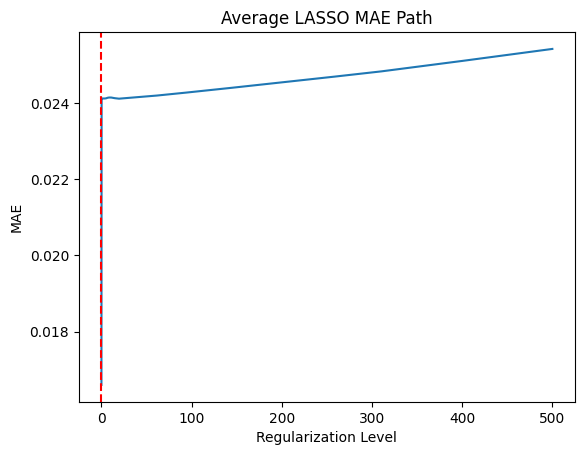

In [50]:
plt.plot(alphas, rmses)
plt.axvline(x=optimal_alpha, color='red', linestyle='dashed')
ax = plt.gca()
ax.set_title('Average LASSO MAE Path')
ax.set_xlabel('Regularization Level')
ax.set_ylabel('MAE')

## Ethics

All data used was obtained legally and is publicly made available by the Central Bureau of Statistics (CBS) of the Netherlands. The database was created by the CBS based on offences registered and published by local police forces and the Royal Netherlands Marechaussee. When dealing with data from CBS we are awere of the potential bias that government instances might have when it comes to data. However, the Netherlands has a good system of checks and balances in place which when taken into consideration vouches for the trustworthiness of the CBS.

On another note, any predictory model to predict crime rates based on features such as average income, minority populations, unemployment rates and population density rightly raises extreme ethical concerns. A model as the one created can provide very useful insights into socio-economic factors that contribute to crime, but can also reinforce harmful stereotypes and biases toward certain racial groups or class of people. 

One such ethical issue is that of discrimination against minority groups: if a model such as this one suggests that municipalities with a higher percentage of certain racial groups are likely more dangerous areas, it could lead to more extreme policing. This could create a larger barrier between the different racial groups, countering the integration and diverse society that cities strive to be. If individuals from these groups are policed more strongly, or randomly checked on the street by officers, it could exacerbate these existing inequalities.

Furthermore, predictory models are extremely subject to bias and errors. There is no guarantee that the training data used in the model is representative of the entire population, easily leading to possible inaccurate results. If this is the case, policy decisions such as police budgets being divided across municipalities may be flawed, as well as the targeting of certain communities as mentioned in the preceding paragraph.

These ethical concerns will never truly be eliminated, but it is important to ensure that the training data of the regression models is anonymized appropriately, representative and unbiased. These models should also be as transparent as possible (not a black-box), so that the public can see for themselves what factors are driving these decisions.

Ethical considerations
- Provide Datasheets for the Dataset (see portal)
- How did you get the data (legally...)?
- Did you check the source?
- Are there considerations about the analysis you
made?
- Did you have to make decisions that affect the
analysis?
- What are the limitations of your analysis and your
conclusions?
- Who are the stakeholders of your project?
- Who can benefit from this project, who can be
harmed, who is excluded, etc.